In [8]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import osmnx as ox
import contextily as cx
from street_continuity import StreetContinuity
from search_information import SearchInformation

<h2>Get map graph</h2>

In [9]:
place = 'Cidade Jardim, São Carlos, São Paulo, Brazil'

# lat = -22.0163
# long = -47.8900

# G = ox.graph_from_point((lat,long), dist=1500, network_type='drive')

G = (ox.graph_from_place(place))

G = ox.get_undirected(ox.projection.project_graph(G))


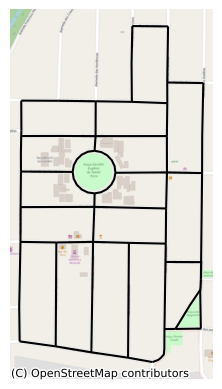

In [10]:
nodes, streets  = ox.graph_to_gdfs(G)

ax = streets.plot(color="k")
cx.add_basemap(ax, crs=streets.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.axis("off")

plt.show()

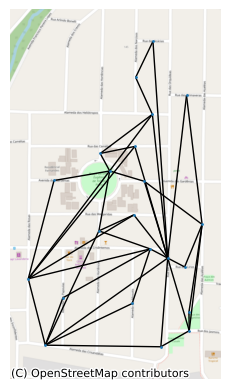

In [14]:
nG = StreetContinuity.get_dual_graph(G)

fig, ax = plt.subplots()

nx.draw(
    nG, {idx: [data['x'], data['y']] for idx, data in list(nG.nodes(data=True))},ax=ax, node_size=1
)
cx.add_basemap(ax, crs=G.graph['crs'], source=cx.providers.OpenStreetMap.Mapnik)
ax.axis("off")

plt.show()

In [15]:
len(nG.nodes)

22

In [16]:

si = SearchInformation(nG)

si.compute_average_search_information()

si.get_average_search_information()


4.56256098743737